<i><b>Public AI</b></i>
<br>
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 1. DNN Basis**
# Section 8. 심층 신경망 분류기 만들기


### _Objective_
1. 텐서플로우를 활용해 심층 신경망 분류기를 만들어봅니다. 
2. 하이퍼파라미터를 결정하여 모델을 학습시켜봅니다. 

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### 예제 데이터 ) 암 환자 데이터 셋

나이와 종양크기를 바탕으로 암 환자의 종양이 양성인지 음성인지를 분류하는 데이터셋입니다.

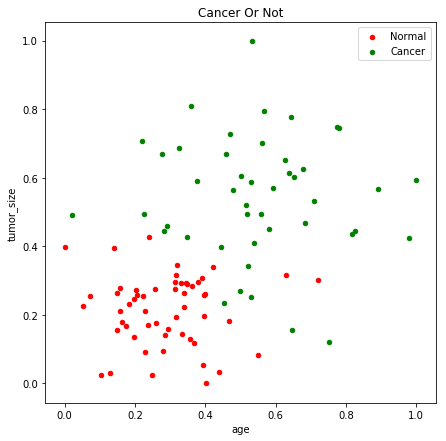

In [2]:
if not os.path.exists("./cancer_dataset.csv"):
    !wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cancer_dataset.csv
cancer_df = pd.read_csv('cancer_dataset.csv')

X = cancer_df[['age','tumor_size']]
y = cancer_df["label"]

X = (X - X.min()) / (X.max() - X.min())

### 데이터 시각화
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

# 0: 정상
X[y==0].plot('age','tumor_size',ax=ax,legend=True,
                           kind='scatter',color='red')
# 1: 암환자
X[y==1].plot('age','tumor_size',ax=ax,legend=True,
                           kind='scatter',color='green')
plt.legend(['Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

## 1. Network Model 생성하기



앞서 심층 신경망 모델의 개념을 배우며 텐서플로우를 이용해 간략하게 1번째 층의 유닛이 10개인 신경망 모델을 만들어봤습니다. 이번에는 1번째 층의 유닛이 200개인 신경망을 만들어봅시다. 

In [3]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [4]:
K.clear_session()
inputs = Input(2,name='x')

dense1 = Dense(200, activation='relu', name='dense_1',)
dense1_output = dense1(inputs)

dense2 = Dense(1, activation='sigmoid', name='dense_2')
dense2_output = dense2(dense1_output)

model = Model(inputs, dense2_output, name='model')

In [5]:
plot_model(model,show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


## 2. 학습을 위해 Model 학습과정 설정하기

keras에서는 `compile()`함수를 사용해 학습하기 전에 학습에 대한 설정을 수행합니다. (1) 최적화 함수, (2) 손실 함수, (3) 평가 지표 등을 결정하여 모델을 준비하는 방법을 알아보고, (4) 준비된 최적화 함수, 손실 함수, 평가지표 등으로 구성된 모델을 컴파일하는 방법을 알아봅시다. 

### (1) 최적화 함수 결정하기

신경망 학습의 목적은 Loss Function의 결과값을 최소화하는 매개변수를 찾는 것입니다. 즉, 매개변수의 최적값을 찾는 것이 신경망 학습의 주된 문제이며 이러한 문제를 푸는 것을 **최적화**라고 합니다.최적화를 도와주는 함수로는 `SGD`, `momentum`, `NAG`, `Adagrad`, `RMSprop`, `Adam`등이 있습니다. 각 최적화 함수는 exercise에서 더 자세히 다뤄볼 것입니다.<br> 

keras에서는 아래와 같이 최적화 함수를 적용할 수 있습니다.

In [6]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop, Adam

In [7]:
optim = SGD(learning_rate=1e-2)
optim = RMSprop(learning_rate=1e-2, rho=0.9)
optim = Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999)

최적화 함수와 같이 직접 설정해주어야 하는 매개변수를 **하이퍼파라미터**라고 합니다. 하이퍼파라미터는 편향(bias)나 가중치(weight) 같은 신경망의 매개변수와는 성질이 다른 매개변수입니다. 신경망의 가중치는 훈련데이터와 학습 알고리즘에 의해서 자동으로 획득되는 매개변수인 반면, 최적화 함수와 같은 하이퍼파라미터는 사람이 직접 설정해야 하는 매개변수입니다. 일반적으로 이 하이퍼파라미터들은 여러 후보 값 중에서 시험을 통해 가장 잘 학습하는 값을 찾는 과정을 거쳐야 하는데, 이 과정을 하이퍼파라미터 최적화라고 합니다.

### (2) 손실함수 결정하기

손실함수에는 MSE외에 mean_absolute_error, categorical_crossentropy, binary_crossentropy등의 종류가 있습니다. MAE(mean_absolute_errer)는 MSE에서 제곱 대신 절댓값을 취한 함수로 특이점에 크게 영향을 받지 않는다는 장점이 있습니다. 보통 classification문제를 해결할 때 crossentropy 함수들을 사용합니다. <br>

아래의 표는 모델에 맞는 마지막 층의 활성화 함수와 손실 함수 선택을 정리한 표입니다.

| 문제 유형 | 마지막 층의 활성화 함수 | 손실 함수 |
| --- | --- | --- |
| 이진 분류 | 시그모이드 | binary_crossentropy |
| 단일 label 다중 분류 | 소프트맥스 | categorical_crossentropy |
| 다중 label 다중 분류 | 시그모이드 | binary_crossentropy |
| 임의 값에 대한 회귀 | 없음 | mse |
| 0과 1 사이 값에 대한 회귀 | 시그모이드 | mse 또는 binary_crossentropy|

In [8]:
from tensorflow.keras.losses import BinaryCrossentropy

loss_func = BinaryCrossentropy()

### (3)  평가 지표 결정하기

keras에서는 `tensorflow.keras.metrics`를 통해 평가 지표를 설정할 수 있습니다. 주요 평가지표로는 정확도를 나타내는 accuracy, binary_accuracy, categorical_accuracy, 상위 k개 예측값의 정확도를 나타내는 top_k_categorical_accuracy등이 있습니다.

In [9]:
from tensorflow.keras.metrics import BinaryAccuracy

In [10]:
metric_func = BinaryAccuracy()

### (4) 모델 컴파일하기

keras의 `compile()` 과정에서 우리는 하이퍼파라미터인 최적화 함수, 손실함수, 평가 지표를 설정합니다. 이 과정에서 케라스의 기본 백엔드인 tensorflow에서는 최적화 함수, 손실함수, 평가 지표를 연결하여 계산 그래프 구성을 마무리하는 작업이 수행됩니다.

In [11]:
model.compile(optimizer=optim,
              loss=loss_func,
              metrics=[metric_func])

## 3. Model 학습시키기

keras에서는 `fit()`함수를 사용해 훈련셋을 이용하여 구성한 모델로 학습시킵니다.

`fit()` 함수의 주요 인자로는 epoch와 batch_size가 있습니다. 전체 훈련 데이터에 수행되는 각 반복을 **에포크(Epoch)**라고 합니다. 각 epoch마다 네트워크가 배치에서 손실에 대한 가중치의 그래디언트를 계산하고 그에 맞추어 가중치를 업데이트 합니다. batch_size는 기본 32로 설정되어 있습니다. 한 번에 32개의 데이터씩 처리한다는 의미입니다. 

In [12]:
history = model.fit(X, y, epochs=500, verbose=2)

W0109 15:28:33.683228 4562775488 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


Train on 100 samples
Epoch 1/500
100/100 - 0s - loss: 0.6736 - binary_accuracy: 0.5400
Epoch 2/500
100/100 - 0s - loss: 0.6170 - binary_accuracy: 0.8600
Epoch 3/500
100/100 - 0s - loss: 0.5593 - binary_accuracy: 0.8900
Epoch 4/500
100/100 - 0s - loss: 0.5003 - binary_accuracy: 0.9300
Epoch 5/500
100/100 - 0s - loss: 0.4383 - binary_accuracy: 0.9200
Epoch 6/500
100/100 - 0s - loss: 0.3868 - binary_accuracy: 0.9200
Epoch 7/500
100/100 - 0s - loss: 0.3353 - binary_accuracy: 0.9100
Epoch 8/500
100/100 - 0s - loss: 0.2939 - binary_accuracy: 0.9200
Epoch 9/500
100/100 - 0s - loss: 0.2796 - binary_accuracy: 0.9000
Epoch 10/500
100/100 - 0s - loss: 0.2652 - binary_accuracy: 0.9300
Epoch 11/500
100/100 - 0s - loss: 0.2422 - binary_accuracy: 0.9000
Epoch 12/500
100/100 - 0s - loss: 0.2269 - binary_accuracy: 0.9200
Epoch 13/500
100/100 - 0s - loss: 0.2165 - binary_accuracy: 0.9200
Epoch 14/500
100/100 - 0s - loss: 0.2238 - binary_accuracy: 0.9000
Epoch 15/500
100/100 - 0s - loss: 0.2134 - binary_

Epoch 123/500
100/100 - 0s - loss: 0.1698 - binary_accuracy: 0.9200
Epoch 124/500
100/100 - 0s - loss: 0.1770 - binary_accuracy: 0.9400
Epoch 125/500
100/100 - 0s - loss: 0.1742 - binary_accuracy: 0.9100
Epoch 126/500
100/100 - 0s - loss: 0.1751 - binary_accuracy: 0.9300
Epoch 127/500
100/100 - 0s - loss: 0.1751 - binary_accuracy: 0.9200
Epoch 128/500
100/100 - 0s - loss: 0.1721 - binary_accuracy: 0.9200
Epoch 129/500
100/100 - 0s - loss: 0.1756 - binary_accuracy: 0.9200
Epoch 130/500
100/100 - 0s - loss: 0.1719 - binary_accuracy: 0.9300
Epoch 131/500
100/100 - 0s - loss: 0.1698 - binary_accuracy: 0.9300
Epoch 132/500
100/100 - 0s - loss: 0.1802 - binary_accuracy: 0.9300
Epoch 133/500
100/100 - 0s - loss: 0.1842 - binary_accuracy: 0.9500
Epoch 134/500
100/100 - 0s - loss: 0.1768 - binary_accuracy: 0.9400
Epoch 135/500
100/100 - 0s - loss: 0.1710 - binary_accuracy: 0.9300
Epoch 136/500
100/100 - 0s - loss: 0.1724 - binary_accuracy: 0.9400
Epoch 137/500
100/100 - 0s - loss: 0.1716 - bina

Epoch 244/500
100/100 - 0s - loss: 0.1577 - binary_accuracy: 0.9400
Epoch 245/500
100/100 - 0s - loss: 0.1674 - binary_accuracy: 0.9400
Epoch 246/500
100/100 - 0s - loss: 0.1692 - binary_accuracy: 0.9500
Epoch 247/500
100/100 - 0s - loss: 0.1586 - binary_accuracy: 0.9300
Epoch 248/500
100/100 - 0s - loss: 0.1749 - binary_accuracy: 0.9200
Epoch 249/500
100/100 - 0s - loss: 0.1752 - binary_accuracy: 0.9200
Epoch 250/500
100/100 - 0s - loss: 0.1600 - binary_accuracy: 0.9300
Epoch 251/500
100/100 - 0s - loss: 0.1543 - binary_accuracy: 0.9300
Epoch 252/500
100/100 - 0s - loss: 0.1663 - binary_accuracy: 0.9200
Epoch 253/500
100/100 - 0s - loss: 0.1687 - binary_accuracy: 0.9300
Epoch 254/500
100/100 - 0s - loss: 0.1547 - binary_accuracy: 0.9400
Epoch 255/500
100/100 - 0s - loss: 0.1549 - binary_accuracy: 0.9400
Epoch 256/500
100/100 - 0s - loss: 0.1587 - binary_accuracy: 0.9500
Epoch 257/500
100/100 - 0s - loss: 0.1579 - binary_accuracy: 0.9500
Epoch 258/500
100/100 - 0s - loss: 0.1571 - bina

Epoch 365/500
100/100 - 0s - loss: 0.1407 - binary_accuracy: 0.9400
Epoch 366/500
100/100 - 0s - loss: 0.1421 - binary_accuracy: 0.9400
Epoch 367/500
100/100 - 0s - loss: 0.1416 - binary_accuracy: 0.9400
Epoch 368/500
100/100 - 0s - loss: 0.1401 - binary_accuracy: 0.9400
Epoch 369/500
100/100 - 0s - loss: 0.1471 - binary_accuracy: 0.9400
Epoch 370/500
100/100 - 0s - loss: 0.1494 - binary_accuracy: 0.9300
Epoch 371/500
100/100 - 0s - loss: 0.1430 - binary_accuracy: 0.9500
Epoch 372/500
100/100 - 0s - loss: 0.1499 - binary_accuracy: 0.9400
Epoch 373/500
100/100 - 0s - loss: 0.1540 - binary_accuracy: 0.9500
Epoch 374/500
100/100 - 0s - loss: 0.1527 - binary_accuracy: 0.9400
Epoch 375/500
100/100 - 0s - loss: 0.1494 - binary_accuracy: 0.9400
Epoch 376/500
100/100 - 0s - loss: 0.1438 - binary_accuracy: 0.9500
Epoch 377/500
100/100 - 0s - loss: 0.1408 - binary_accuracy: 0.9500
Epoch 378/500
100/100 - 0s - loss: 0.1432 - binary_accuracy: 0.9500
Epoch 379/500
100/100 - 0s - loss: 0.1474 - bina

Epoch 486/500
100/100 - 0s - loss: 0.1261 - binary_accuracy: 0.9400
Epoch 487/500
100/100 - 0s - loss: 0.1322 - binary_accuracy: 0.9300
Epoch 488/500
100/100 - 0s - loss: 0.1385 - binary_accuracy: 0.9300
Epoch 489/500
100/100 - 0s - loss: 0.1370 - binary_accuracy: 0.9300
Epoch 490/500
100/100 - 0s - loss: 0.1320 - binary_accuracy: 0.9400
Epoch 491/500
100/100 - 0s - loss: 0.1282 - binary_accuracy: 0.9400
Epoch 492/500
100/100 - 0s - loss: 0.1261 - binary_accuracy: 0.9300
Epoch 493/500
100/100 - 0s - loss: 0.1252 - binary_accuracy: 0.9400
Epoch 494/500
100/100 - 0s - loss: 0.1342 - binary_accuracy: 0.9500
Epoch 495/500
100/100 - 0s - loss: 0.1302 - binary_accuracy: 0.9500
Epoch 496/500
100/100 - 0s - loss: 0.1263 - binary_accuracy: 0.9400
Epoch 497/500
100/100 - 0s - loss: 0.1250 - binary_accuracy: 0.9400
Epoch 498/500
100/100 - 0s - loss: 0.1269 - binary_accuracy: 0.9400
Epoch 499/500
100/100 - 0s - loss: 0.1252 - binary_accuracy: 0.9500
Epoch 500/500
100/100 - 0s - loss: 0.1233 - bina

한편, keras에서는 `history`함수를 사용해 모델 학습 시 훈련셋, 검증셋의 손실 및 정확도를 측정합니다. 반복횟수에 따른 손실 및 정확도 추이를 보면서 학습 상황을 판단합니다.

아래 그래프를 보면, `epoch = 1000`으로 설정함에 따라, 1000번 반복하여 모델을 훈련하는 과정에서 손실이 줄어드는 것을 확인할 수 있습니다. 

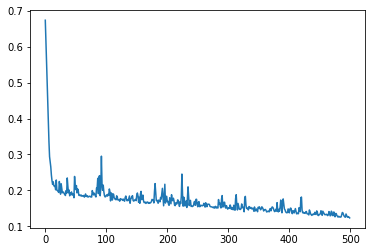

In [13]:
plt.plot(history.history['loss'])
plt.show()

아래 그래프를 보면 1000번을 반복하여 모델을 훈련하는 과정에서 정확도가 올라가는 것을 확인할 수 있습니다.  

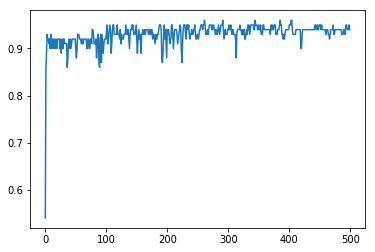

In [14]:
plt.plot(history.history['binary_accuracy'])
plt.show()

## 4. 결과 확인하기

자, 이제 모델을 만들고 학습시켜 보았습니다. `results = model.predict(xs)`를 이용해 만들어진 모델에 데이터를 넣고 결과값을 예측해봅시다. 그래프를 보면, 단순히 직선으로 암 환자와 정상을 구분하지 않고, 다수의 곡선으로 경계가 나뉘어진 것을 확인할 수 있습니다. 

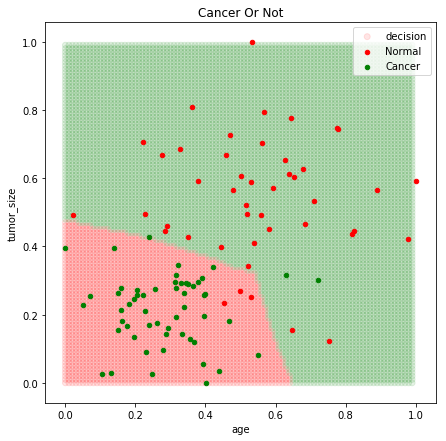

In [15]:
x1s,x2s = np.mgrid[0:1:0.01,0:1:0.01]
xs = np.stack([x1s.ravel(),x2s.ravel()],axis=1)

results = model.predict(xs) # 결과 예측

colors = []
for result in results.ravel():
    if result > 0.5:
        colors.append('g')
    else:
        colors.append('r')
        
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1],c=colors,alpha=0.1)

# 0: 정상
X[y==1].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='red')
# 1: 암환자
X[y==0].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='green')
plt.legend(["decision",'Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/09/16


---